In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import pycountry
import statsmodels.api as sm
import warnings
from statsmodels.stats.diagnostic import het_white
from linearmodels import PanelOLS
from linearmodels.iv import IV2SLS
from patsy import dmatrices
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from linearmodels.panel import compare

# Silencing future warnings to remove clutter
warnings.filterwarnings("ignore", category=FutureWarning)

# Step 1: API Data Requests

## Data Collection
The data was collected using the World Bank API over a span of 20 years. Indicators were identified through the World Bank Website and descriptions were taken from World Development Indicators (World Bank, 2025a; World Bank, 2025b) and World Governance Indicators documentation (World Bank, 2024a)

# Features
The dataset contains the following indicators:

(i) **GDP Per Capita** : Income per person

(ii) **GDP Growth** : Percentage changes in constant-price GDP per annum

(iii) **Gini Index** : Measure of inequality

(iv) **Trade Openness** : Sum of import and exports as % of GDP

(v) **Education Expenditure** : Government spending as a share of GDP

(vi) **FDI Net Inflows (%GDP)** : Net inflows of foreign investment expressed as a percentage of GDP (World Bank, 2025d)

(vii) **Government Effectiveness** : Captures perceptions on governance quality, public services etc. (World Bank, 2024b)

(vii) **Regulatory Quality** : Captures perceptions of government ability to implement policies/regulation that promote private sector development. (World Bank, 2025c)

(viii) **Land Area** : Total area of a country in square kilometres

# API Method
After an initial failed approach, the *pandas_datareader's* **wb** module was used to loop over the indicators across 20 years over all countries. The following two code blocks demonstrate the initial approach and the successful revised approach.

# Roadblock
The code block below showcases a manual API querying method with manual pagination. As can be seen everything past the helper function is commented out, the function will be used once for one year to demonstrate functionality. Due to constant time-outs and exceptions an alternative approach was pursued using the pandas data reader library.

In [6]:
# Helper function to get the data with indicator and year parameters
def get_worldbank(indicator, year, page=1):
    try:
        base_url = "https://api.worldbank.org/v2/country/all/indicator/{code}?date={year}&format=json&per_page=200&page={page}"
        url = base_url.format(code=indicator, year=year, page=page)
        response = requests.get(url, timeout=20)
    except Exception as e:
        print("Exception Raised")
        print(e)
    return response.json()

'''
indicators = {
    "GDP_Per_Capita" : "NY.GDP.PCAP.CD",
    "GDP_Growth" : "NY.GDP.MKTP.KD.ZG",
    "Gini_Index" : "SI.POV.GINI",
    "Education_Exp" : "SE.XPD.TOTL.GD.ZS",
    "Trade_Openness" : "NE.TRD.GNFS.ZS",
    "Govt_Effectiveness" : "GE.EST",
    "Reg_Quality" : "RQ.EST",
    "FDI_Net_Inflows" : "BX.KLT.DINV.WD.GD.ZS",
}

for ind_name, ind_code in indicators.items():
    print(f"Now processing {ind_name}")
    json_data = get_worldbank(ind_code, 2022, 1)
    df = pd.DataFrame(json_data[1])
    # Keeping country column, country code and value for indicator
    df = df[['country', 'countryiso3code', 'value']]
    df['country'] = df['country'].apply(lambda x: x['value'])
    df = df.rename(columns={'value': ind_name, 'countryiso3code': 'iso3'})
    df_list.append(df)

# Same loop running for page 2 of results
for ind_name, ind_code in indicators.items():
    print(f"Now processing {ind_name}")
    json_data = get_worldbank(ind_code, 2022, 2)
    df = pd.DataFrame(json_data[1])
    # Keeping country column, country code and value for indicator
    df = df[['country', 'countryiso3code', 'value']]
    df['country'] = df['country'].apply(lambda x: x['value'])
    df = df.rename(columns={'value': ind_name, 'countryiso3code': 'iso3'})
    df_list.append(df)

# Creating copy of first dataframe to merge country column later
df_copy = df_list[0][['iso3', 'country']].drop_duplicates()
dfs_final = []

# Iterating over indicators to find duplicate columns due to pagination
for ind in indicators:
    # In each iteration find columns with same indicator
    dfs_dupli = [df for df in df_list if ind in df.columns]
    # Concatenate row-wise
    combined = pd.concat(dfs_dupli, ignore_index=True)
    # Finding duplicate iso3 columns
    iso_cols = [col for col in combined.columns if col.startswith('iso3')]
    # Drop duplicate iso3 columns except the first
    combined = combined.drop(columns=iso_cols[1:])
    # Dropping duplicate iso3
    combined = combined.drop_duplicates(subset=['iso3'])
    # Append new dataframe to list
    dfs_final.append(combined)

# Removing country from every dataframe for a clean merge on iso3
for id, df in enumerate(dfs_final):
    if "country" in df.columns:
        dfs_final[id] = df.drop(columns=['country'])

# Take the first dataframe as the baseline to merge
merged = dfs_final[0]

# Can be seen to be the GDP Per Capita
merged.head()

# Iterating over remaining dataframes and merging on country
for df in dfs_final[1:]:
    # Merging on iso3
    merged = merged.merge(df, on='iso3', how="outer")

# Adding country column back
merged = merged.merge(df_copy, on='iso3', how='left')
# Adding country column to the very left
merged = merged[['country'] + [col for col in merged.columns if col!= 'country']]
# Print missing values
print(merged.isna().sum(), "\n")
# Print Shape
print(merged.shape, "\n")
'''

'\nindicators = {\n    "GDP_Per_Capita" : "NY.GDP.PCAP.CD",\n    "GDP_Growth" : "NY.GDP.MKTP.KD.ZG",\n    "Gini_Index" : "SI.POV.GINI",\n    "Education_Exp" : "SE.XPD.TOTL.GD.ZS",\n    "Trade_Openness" : "NE.TRD.GNFS.ZS",\n    "Govt_Effectiveness" : "GE.EST",\n    "Reg_Quality" : "RQ.EST",\n    "FDI_Net_Inflows" : "BX.KLT.DINV.WD.GD.ZS",\n}\n\nfor ind_name, ind_code in indicators.items():\n    print(f"Now processing {ind_name}")\n    json_data = get_worldbank(ind_code, 2022, 1)\n    df = pd.DataFrame(json_data[1])\n    # Keeping country column, country code and value for indicator\n    df = df[[\'country\', \'countryiso3code\', \'value\']]\n    df[\'country\'] = df[\'country\'].apply(lambda x: x[\'value\'])\n    df = df.rename(columns={\'value\': ind_name, \'countryiso3code\': \'iso3\'})\n    df_list.append(df)\n\n# Same loop running for page 2 of results\nfor ind_name, ind_code in indicators.items():\n    print(f"Now processing {ind_name}")\n    json_data = get_worldbank(ind_code, 202

# The improved API method
Using the datareader wb module we loop through all indicator to create new dataframes with panel data over a period of 20 years, then merging into a final dataframe. ISO3 country codes were extracted as well to alleviate formatting issues. A time-invariant indicator, "Land Area", was also merged into the dataframe using the **manual API pagination method**.

In [7]:
from pandas_datareader import wb

# Defining indicator dictionary
indicators = {
    "GDP_Per_Capita" : "NY.GDP.PCAP.CD",
    "GDP_Growth" : "NY.GDP.MKTP.KD.ZG",
    #"Gini_Index" : "SI.POV.GINI",   Gini Index will be taken from an alternative dataset
    "Education_Exp" : "SE.XPD.TOTL.GD.ZS",
    "Trade_Openness" : "NE.TRD.GNFS.ZS",
    "Govt_Effectiveness" : "GE.EST",
    "Reg_Quality" : "RQ.EST",
    "FDI_Net_Inflows" : "BX.KLT.DINV.WD.GD.ZS",
    #"Land_Area" : "AG.LND.TOTL.K2" Will be extracted with manual pagination method
}

# Getting dataframe of country name and codes (iso3)
countries = wb.get_countries()[['name', 'iso3c']]
countries = countries.rename(columns={"name": "Country", "iso3c": "iso3"})

# Empty list for dataframes
df_list = []

# Looping over indicators to download using wb module
for ind_name, ind_code in indicators.items():
    print(f"Processing {ind_name}")

    df = wb.download(
        indicator = ind_code,
        country = 'all',
        start = 2002,
        end = 2022,
    ).reset_index() # Resetting index for merge

    # Renaming columns
    df = df.rename(columns={
        'country' : 'Country', # Upper case
        ind_code : ind_name, # Indicator code to Indicator Name
    })

    # Attaching ISO3s
    df = df.merge(countries, on="Country", how="left")

    # Appending to dataframe list
    df_list.append(df)

# ------------ Manual API ------------
# Creating empty list for land area frames
land_dfs = []

# Manually extracting land area over 2 pages
for p in [1,2]:
    print(f"Now processing Land Area page {p}")
    json_data = get_worldbank("AG.LND.TOTL.K2", 2022, p) # Year is arbirtrary here, it doesn't change
    df1 = pd.DataFrame(json_data[1])
    # Keeping country column, country code and value for indicator
    df1 = df1[['country', 'countryiso3code', 'value']]
    df1['country'] = df1['country'].apply(lambda x: x['value'])
    df1 = df1.rename(columns={'value': 'Land_Area',
                              'countryiso3code': 'iso3',
                              'country': 'Country'})
    # Appending only iso3 and value, time-invariant
    land_dfs.append(df1[['iso3', 'Country', 'Land_Area']])

# Concatenating land dfs
land_df = pd.concat(land_dfs, ignore_index=True)

# Dropping duplicates
land_df = land_df.drop_duplicates(subset=['iso3'])

# Adding land dataframe to dataframe list for merging
df_list.append(land_df)

# ------------ Manual API End ------------


# Taking first frame as baseline to merge
panel_wb = df_list[0]

# Looping over dfs, merging each one
for df in df_list[1:]:
    # Dropping country column
    df = df.drop(columns='Country')
    # Checking if panel data or cross-sectional
    if 'year' in df.columns:
        panel_wb = pd.merge(panel_wb, df, on=['iso3', 'year'], how='outer') # Merging on year
    else:
        panel_wb = pd.merge(panel_wb, df, on=['iso3'], how='left') # Merging on country code

# Moving ISO3 to the very left
cols = panel_wb.columns.to_list()
cols = ['iso3'] + [c for c in cols if c != 'iso3']
panel_wb = panel_wb[cols]

Processing GDP_Per_Capita
Processing GDP_Growth
Processing Education_Exp
Processing Trade_Openness
Processing Govt_Effectiveness
Processing Reg_Quality
Processing FDI_Net_Inflows
Now processing Land Area page 1
Now processing Land Area page 2


# Step 2: Data Cleaning and Pre-Processing

# 2.1 Invalid Rows
Going through the dataset it can be seen how some panels are of regional data or other miscellaneous categories. We can drop them using the pycountry library. The library has a list of all ISO3 country codes which we extract as a set, for uniqueness. We filter the original dataset on the valid iso3 codes and then drop rows which are of invalid country codes.

In [8]:
# Getting ISO3 country codes from pycountry
# Creating set of all country iso3 codes from pycountry
iso3_correct = {c.alpha_3 for c in pycountry.countries}

# Rows before
before = panel_wb.shape[0]

# Filtering based on set and creating new frame
panel_wb_clean = panel_wb[panel_wb['iso3'].isin(iso3_correct)].copy()

#Reseting index
panel_wb_clean.reset_index(drop=True, inplace=True)

# Rows after
after = panel_wb_clean.shape[0]

# Printing how many rows we're dropping
print(f"We dropped {before-after} rows\n")

# Checking for empty country name rows
print(f"We are missing {panel_wb_clean['Country'].isna().sum()} country names")

We dropped 3717 rows

We are missing 0 country names


# 2.2 Gini Index Extraction
Gini coverage from the API is sparse. We will use the SWIID dataset (Solt, 2019) since it offers wider coverage and merge it into our dataframe.

In [9]:
import zipfile, io
url = "https://dataverse.harvard.edu/api/access/datafile/10797566"

# Requesting the file, it is a zip
r = requests.get(url)
# Downloading bytes of the zip, turn bytes into file object and treat it as ZIP archive
z = zipfile.ZipFile(io.BytesIO(r.content))

# Finding the right file, it is swiid9_8/swiid9_8_summary.csv
print(z.namelist())

csv_name =  "swiid9_8/swiid9_8_summary.csv"
# Reading into pandas
swiid = pd.read_csv(z.open(csv_name))


['swiid9_8/', 'swiid9_8/swiid9_8.rda', 'swiid9_8/stata_swiid.pdf', 'swiid9_8/R_swiid.pdf', 'swiid9_8/swiid9_8_summary.csv', 'swiid9_8/swiid9_8.dta']


# Merging the two datasets

## Creating the ISO3 column
After standardizing ISO3 codes using the pycountry library and filter out naming differences, we merge on ISO3 and year. Some countries that were missing due to naming differences were added to an inclusion dictionary with publicly avaibale ISO3 codes.

In [10]:
# Creating sets from the two country columns
swiid_set = set(swiid['country'].unique())
wb_set = set(panel_wb_clean['Country'].unique())

# Finding set difference
set_diff = swiid_set - wb_set
print("In SWIID but not in merged dataframe")
print(set_diff)
print(f"Missing {len(set_diff)} countries\n")

# Creating iso3 getter helper function
def get_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3     #alpha_3 gives ISO3
    except:
        return None

# Creating iso3 column for swiid to merge
swiid['iso3'] = swiid['country'].apply(get_iso3)

# Seeing if we are missing
print(f"{swiid['iso3'].isna().sum()} missing ISO3s\n")

# Dropping countries that no longer exist
defunct_countries = ['Czechoslovakia', 'Yugoslavia', 'Soviet Union']
swiid = swiid[~swiid['country'].isin(defunct_countries)]

# Creating dictionary of missing values due to different formatting
iso_swiid_dict = {
    "Egypt": "EGY",
    "Micronesia": "FSM",
    "Venezuela": "VEN",
    "St. Vincent and Grenadines": "VCT",
    "Palestinian Territories": "PSE",
    # Democratic Republic
    "Congo-Kinshasa": "COD",
    "Anguilla": "AIA",
    "Turkey": "TUR",
    "Iran": "IRN",
    "Laos": "LAO",
    "Kyrgyzstan": "KGZ",
    "Cape Verde": "CPV",
    "Vietnam": "VNM",
    "Côte d'Ivoire": "CIV",
    "Tanzania": "TZA",
    "Kosovo": "XKX",
    # Republic
    "Congo-Brazzaville": "COG",
    "Czech Republic": "CZE",
    "Russia": "RUS",
    "Gambia": "GMB",
    "Korea": 'KOR',
    "Taiwan": "TWN",
    "Hong Kong": "HKG",
    "Bahamas": "BHS",
    "São Tomé and Príncipe": "STP",
    "St. Lucia": "LCA",
    "Brunei": "BRN",
    "St. Kitts and Nevis": "KNA",
    "Syria": "SYR"
}

# Mapping dictionary to missing iso3 values
swiid['iso3'] = swiid['iso3'].fillna(
    swiid['country'].map(iso_swiid_dict)
)

# Checking for missing ISOs
print(f"{swiid['iso3'].isna().sum()} missing ISO3s\n")

In SWIID but not in merged dataframe
{'Brunei', 'Gambia', 'Egypt', 'Puerto Rico', 'Congo-Kinshasa', 'Anguilla', 'Soviet Union', 'Palestinian Territories', 'Laos', 'Kyrgyzstan', "Côte d'Ivoire", 'Taiwan', 'Bahamas', 'Korea', 'Yugoslavia', 'Venezuela', 'Slovakia', 'Turkey', 'Syria', 'Czech Republic', 'Hong Kong', 'Yemen', 'Iran', 'São Tomé and Príncipe', 'Vietnam', 'Kosovo', 'St. Vincent and Grenadines', 'Russia', 'Somalia', 'Micronesia', 'Cape Verde', 'Congo-Brazzaville', 'Czechoslovakia'}
Missing 33 countries

341 missing ISO3s

0 missing ISO3s



## Merging on Year and ISO3
First we check if the two dataframes have the same data type for year, transform if not, then merge the two dataframes on ISO3 and Year.

In [11]:
print(swiid.info(),'\n')
print(panel_wb_clean.info(), '\n')

# Changing datatype of year to integer
panel_wb_clean['year'] = panel_wb_clean['year'].astype(int)

<class 'pandas.core.frame.DataFrame'>
Index: 6344 entries, 0 to 6397
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       6344 non-null   object 
 1   year          6344 non-null   int64  
 2   gini_disp     6344 non-null   float64
 3   gini_disp_se  6344 non-null   float64
 4   gini_mkt      6344 non-null   float64
 5   gini_mkt_se   6344 non-null   float64
 6   abs_red       2685 non-null   float64
 7   abs_red_se    2685 non-null   float64
 8   rel_red       2685 non-null   float64
 9   rel_red_se    2685 non-null   float64
 10  iso3          6344 non-null   object 
dtypes: float64(8), int64(1), object(2)
memory usage: 594.8+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   iso3                4515 non-null   object 
 1   Country  

In [12]:
# Extracting just iso3, gini column and year
swiid_gini = swiid[['iso3', 'year', 'gini_disp']].copy()

# Merging dataset on year and iso3 (if condition for replicability)
if "Gini_Index" not in panel_wb_clean.columns:
    panel_wb_clean = panel_wb_clean.merge(swiid_gini, on=['iso3','year'], how='left')
    # Renaming column to Gini_Index
    panel_wb_clean = panel_wb_clean.rename(columns={'gini_disp' : 'Gini_Index'})

# Displaying missing Gini rows
print(f"{panel_wb_clean['Gini_Index'].isna().sum()} missing Gini values")

# Moving Land Area column to very right
col_order = panel_wb_clean.columns.to_list()
col_order.remove('Land_Area')
col_order.append('Land_Area')
panel_wb_clean = panel_wb_clean[col_order]

1305 missing Gini values


# 2.3 Imputation (for Regressions)

## Linear Interpolation
We will use linear interpolation to impute the values since it maintains within-country variation. To fine-tune the imputation we calculate persistence scores, the correlation of a variable with its lagged value, to find which variables are most appropriate for "smoothing". All columns with high persistence will have all their values interpolated, less the edge cases that interpolation fails to impute. Intermediate and low persistence will face a limit on consecutive missing rows to not overly smooth the data.

In [13]:
# Creating copy of raw dataframe
panel_wb_imputed = panel_wb_clean.copy()

# Creating helper function for calculating persistence
def var_persistence(df, var):
    # Making sure the years and countries are sorted
    df = df.sort_values(['iso3', 'year'])

    # Creating a lagged variable column
    df[f"{var}_Lag1"] = df.groupby("iso3")[var].shift(1)

    # Calculating correlation and extracting value from matrix
    corr = df[[var,f"{var}_Lag1"]].corr().iloc[0, 1]

    # Returning correlation
    return corr

# Creating list of numeric columns
numeric_cols = panel_wb_imputed.select_dtypes(include='number').columns.to_list()

# Dropping year column and land area from list
numeric_cols.remove('year')
numeric_cols.remove('Land_Area')

# Looping over columns to see persistence and adding column names to list based on persistence
for col in numeric_cols:
    pers = var_persistence(panel_wb_imputed, col)
    print(f"Persistence: {col} : {pers}\n")
    # Checking for high persistence (0.85) and applying interpolation to all rows
    if pers > 0.85:
        panel_wb_imputed[col] = panel_wb_imputed.groupby('iso3')[col].transform(
            lambda c : c.interpolate(limit_direction='both'))
    # Checking for intermediate persistence (0.5) and applying interpolation to up to 3 consecutive missing rows
    elif pers > 0.5:
        panel_wb_imputed[col] = panel_wb_imputed.groupby('iso3')[col].transform(
            lambda c : c.interpolate(limit=3, limit_direction='both'))
    # Otherwise the persistence is weak and only interpolate up to 1 consecutive missing row
    else:
        panel_wb_imputed[col] = panel_wb_imputed.groupby('iso3')[col].transform(
            lambda c : c.interpolate(limit=1, limit_direction='both'))

Persistence: GDP_Per_Capita : 0.9922677449132742

Persistence: GDP_Growth : 0.16842811933395918

Persistence: Education_Exp : 0.9320056635588188

Persistence: Trade_Openness : 0.9633594025337419

Persistence: Govt_Effectiveness : 0.990598337558557

Persistence: Reg_Quality : 0.991733392709829

Persistence: FDI_Net_Inflows : 0.5900266147622736

Persistence: Gini_Index : 0.9991886574691943



In [14]:
# Finding total sum of sums of missing values on raw dataset
before_missing = sum(panel_wb_clean.isna().sum())
# Finding total sum of sums of missing values on processed dataset
after_missing = sum(panel_wb_imputed.isna().sum())

print(f"We have filled in {before_missing - after_missing} values\n")

# Checking which are still missing
panel_wb_imputed.isna().sum()

We have filled in 2559 values



iso3                    0
Country                 0
year                    0
GDP_Per_Capita         63
GDP_Growth            167
Education_Exp         336
Trade_Openness        483
Govt_Effectiveness    231
Reg_Quality           231
FDI_Net_Inflows       412
Gini_Index            525
Land_Area               0
dtype: int64

# 2.4 Saving The Cleaned Dataframes
Having cleaned our data and performed the necessary pre-processing steps we will save the raw cleaned version along with the imputed cleaned version for further analysis.

In [15]:
# Saving raw dataset
panel_wb_clean.to_csv("wb_raw.csv", index=False)

# Saving imputed dataset
panel_wb_imputed.to_csv("wb_imputed.csv", index=False)

# Step 3: Exploratory Analysis
We will calculate descriptive statistics, ranges, variances and standard deviations of each numeric column, less the Land Area. This variable is replicated across each panel since it is time-invariant, we will analyse it by itself by dropping duplicates row-wise.

## 3.1 Descriptive Statistics
+ Can identify outliers, skewness and type of distributions
+ If mean is higher than the median it is right-skewed (e.g. GDP per capita) and vice-versa for left-skewness
+ Ranges, mean and standard deviation can inform us on the type of distribution (e.g. Govt. Effectiveness is approximately normal; almost 0 mean, same absolute min/max value, std dev of approximately 1)
+ Extreme outliers have economic interpretations, e.g. GDP Growth of -54% hints towards a depression, and may require log transformations

In [16]:
# Importing raw dataset
wb_raw = pd.read_csv("wb_raw.csv")

# Importing imputed dataset
wb_imputed = pd.read_csv("wb_imputed.csv")

# Excluding year and land area column from analysis
wb_stat = wb_raw.copy()
wb_stat.drop(columns=['year', 'Land_Area'], inplace=True)

# Descriptive statistics
print("--------Descriptive Stats--------")
print(f"{wb_stat.describe()}\n")

--------Descriptive Stats--------
       GDP_Per_Capita   GDP_Growth  Education_Exp  Trade_Openness  \
count     4386.000000  4330.000000    2976.000000     3777.000000   
mean     16343.139799     3.325970       4.386914       91.125718   
std      25082.645980     6.009641       1.971352       59.278484   
min        109.593814   -54.336106       0.000004        2.698834   
25%       1649.323704     1.169075       3.071372       55.784126   
50%       5656.586863     3.537641       4.199421       78.814980   
75%      21303.481866     5.997803       5.372008      108.869117   
max     226052.001905    91.137039      16.230376      863.195099   

       Govt_Effectiveness  Reg_Quality  FDI_Net_Inflows   Gini_Index  
count         4199.000000  4199.000000      4036.000000  3210.000000  
mean            -0.028098    -0.028528         9.442848    38.649533  
std              0.996390     0.996695        64.892966     7.923534  
min             -2.440229    -2.547726     -1303.108267    2

## 3.2 Ranges, Variances and Standard Deviations
+ GDP Per Capita has highest range. It is to be expected since it is a level dollar amount
+ Govt Effectiveness and Regulatory Quality have lowest ranges, they're approximately normal
+ GDP Per Capita, Trade Openness and FDI Net Inflows have high standard, they may require log transformation for normality.

In [17]:
# Finding range of each value
range_df = wb_stat.max(numeric_only=True) - wb_stat.min(numeric_only=True)
print("--------Ranges--------")
print(f"{range_df}\n")

# Variance and Standard Deviations
print("--------Variance--------")
print(f"{wb_stat.var(numeric_only=True)}\n")
print("--------Standard Deviations--------")
print(f"{wb_stat.std(numeric_only=True)}\n")

--------Ranges--------
GDP_Per_Capita        225942.408092
GDP_Growth               145.473145
Education_Exp             16.230372
Trade_Openness           860.496265
Govt_Effectiveness         4.909889
Reg_Quality                4.799961
FDI_Net_Inflows         3012.935499
Gini_Index                42.700000
dtype: float64

--------Variance--------
GDP_Per_Capita        6.291391e+08
GDP_Growth            3.611579e+01
Education_Exp         3.886229e+00
Trade_Openness        3.513939e+03
Govt_Effectiveness    9.927937e-01
Reg_Quality           9.934014e-01
FDI_Net_Inflows       4.211097e+03
Gini_Index            6.278239e+01
dtype: float64

--------Standard Deviations--------
GDP_Per_Capita        25082.645980
GDP_Growth                6.009641
Education_Exp             1.971352
Trade_Openness           59.278484
Govt_Effectiveness        0.996390
Reg_Quality               0.996695
FDI_Net_Inflows          64.892966
Gini_Index                7.923534
dtype: float64



## 3.3a Quick look at Land Area
Descriptive statistics will be calculated and interpreted for land area. We will then logarithmically transform the variable and plot both series in box-and-whisker form. **This will demonstrate how log transformations alleviate skew and compress outliers**.

In [18]:
# Dropping all duplicate country rows [collapsing panel to cross-section] and only keeping land area column
wb_land = wb_raw.copy()
wb_land = wb_land.drop_duplicates(subset='iso3')
wb_land = wb_land[['iso3', 'Land_Area']]

# Range
range_land = wb_land.max(numeric_only=True) - wb_land.min(numeric_only=True)
print("--------Range--------")
print(f"{range_land}\n")

# Descriptive statistics
wb_land.describe()

--------Range--------
Land_Area    1.637687e+07
dtype: float64



,Land_Area
count,2.150000e+02
mean,6.035471e+05
std,1.750695e+06
min,2.084000e+00
25%,1.017500e+04
50%,9.428000e+04
75%,4.495800e+05
max,1.637687e+07


+ Mean is far above the median (603,547 > 94,280) meaning it is extremely right-skewed
+ Range is enormous at 16,376,870
+ Extremely high SD, pushed by extreme outlier (e.g. Russia)

## 3.3b Box-and-Whisker plots for Land Area


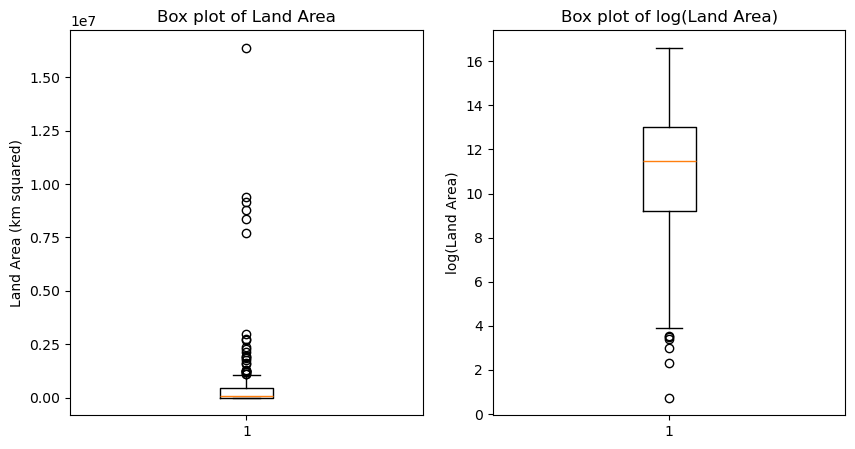

In [19]:
# Defining plot size
plt.figure(figsize=(10,5))

# Size of subplot matrix
plt.subplot(1,2,1) # 1 row, 2 columns, index 1
plt.boxplot(wb_land['Land_Area'])
plt.title('Box plot of Land Area')
plt.ylabel('Land Area (km squared)')

# Size of subplot matrix
plt.subplot(1,2,2) # 1 row, 2 columns, index 2
plt.boxplot(np.log(wb_land['Land_Area'])) # Taking logarithm
plt.title('Box plot of log(Land Area)')
plt.ylabel('log(Land Area)')

plt.show()

+ Raw Data:
    + Extreme outlier spanning order of magnitudes over upper whisker
    + Median is compressed downwards
+ Transformed Data:
    + Partially normalises distribution, symmetrical spread, no extreme outliers
    + Interpretable: Interquartile range spans from ~ln(9)-ln(13), Median at ~ln(11.5)

## 3.4 Correlations
A correlation matrix will be designed to find interesting relationships and multicolinearities within our variables. If two variables are highly colinear they must not be regressed together as it will harm the precision of the estimator.

In [20]:
# Selecting all numeric columns
num = wb_raw[[col for col in wb_raw.columns if col != "Country"
              and col !="year" and col != 'iso3']]

# Correlation Matrix
corr = num.corr()
print(corr, "\n")

# Finding highly correlated variables to avoid multicolinearity in regressions later on

# Creating empty list of corr values to check for duplicates
corr_values = []

# Looping over columns to find correlations which exceed threshold
for col1 in num.columns:
    for col2 in num.columns:
        if col1 != col2:
            corr_value = corr.loc[col1, col2]
            # Cutoff is set at 0.7, absolute value for both negative and positive correlation
            if abs(corr_value) > 0.7 and corr_value not in corr_values:
                print(f"{col1} with {col2}: {abs(corr_value)}")
                corr_values.append(corr_value)

                    GDP_Per_Capita  GDP_Growth  Education_Exp  Trade_Openness  \
GDP_Per_Capita            1.000000   -0.080560       0.031910        0.331867   
GDP_Growth               -0.080560    1.000000      -0.114820        0.015903   
Education_Exp             0.031910   -0.114820       1.000000        0.067384   
Trade_Openness            0.331867    0.015903       0.067384        1.000000   
Govt_Effectiveness        0.700918   -0.105384       0.246728        0.366019   
Reg_Quality               0.664790   -0.109726       0.153606        0.343844   
FDI_Net_Inflows           0.245313    0.000170      -0.022534        0.200137   
Gini_Index               -0.496290    0.085503      -0.165906       -0.249229   
Land_Area                -0.004198    0.025018      -0.013026       -0.222028   

                    Govt_Effectiveness  Reg_Quality  FDI_Net_Inflows  \
GDP_Per_Capita                0.700918     0.664790         0.245313   
GDP_Growth                   -0.105384    -0.

+ GDP Per Capita and Govt Effectiveness: highly correlated (0.7), must not be regressed together.
+ Government Effectiveness and Regulatory Quality: very highly correlated (0.93), must be substituted for one another

## 3.5 Histograms

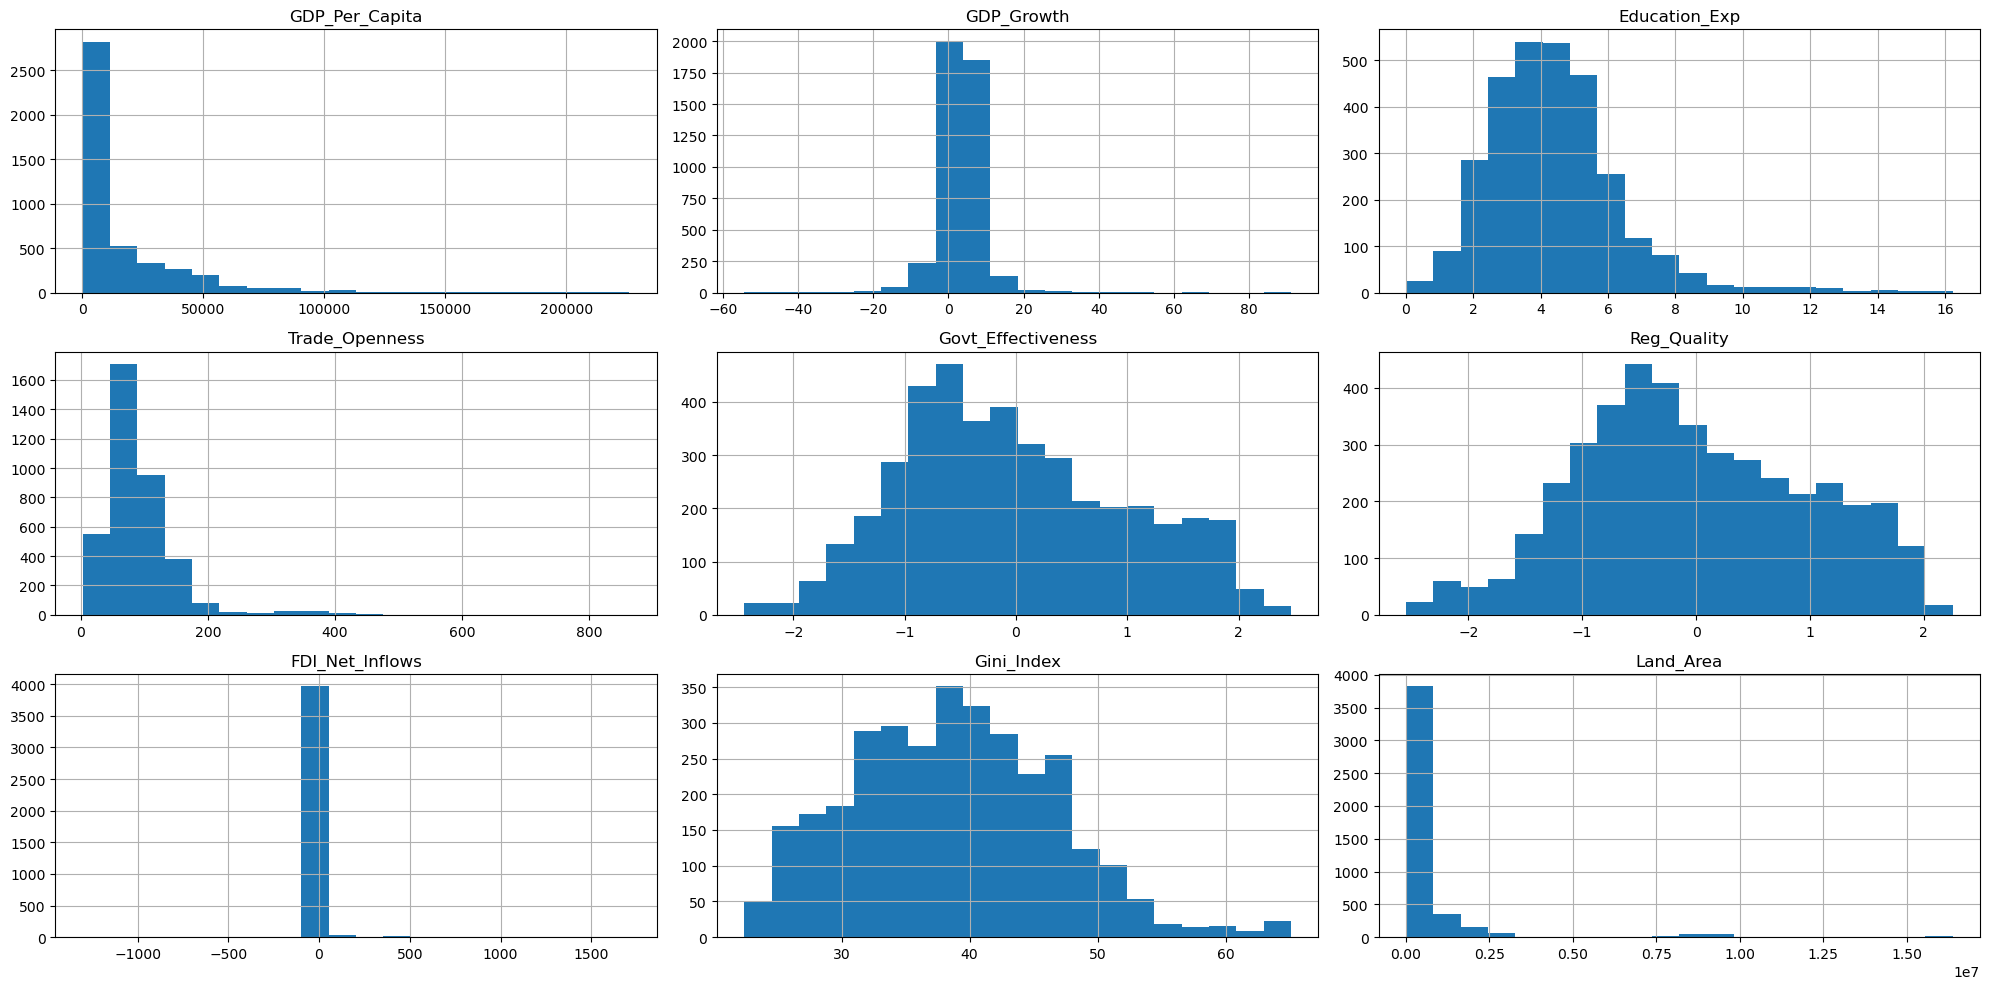

In [21]:
# Histograms
num.hist(figsize=(20, 10), bins=20)
plt.tight_layout()
plt.show()

## Interpretation of Histograms and Transformation Implications
We can observe that GDP Per Capita, Trade Openness, Education Expenditure and particularly FDI Inflows and Land Area are heavily skewed. To make the distribution more symmetrical and reduce the influence of extreme outliers we can logarithmically transform these columns.

## 3.5 Feature Engineering

### Log transformations
GDP per capita, Trade Openness, Education Expenditure, Land Area and FDI Inflows will be logarithmically transformed to alleviate the issues of skewness and extreme outliers. Since FDI has negative values we transform with the inverse hyperbolic sine function (Bellemare and Wichman, 2020):
$$
\operatorname{asinh}(x) = \ln\left(x + \sqrt{x^{2} + 1}\right)
$$
### $\text{Gini}^2$
We will create a new non-linear term, Gini Squared, which is a squared transformation of the Gini Index. This is in line with the Kuznets hypothesis of a U-shaped degree of inequality.

## Interaction Terms
The interaction terms are founded on some common assumptions:

### Log Education Expenditure with Government Effectiveness
Assumption: More spending on education means the government is more effective and vice-versa

### Log of GDP per Capita with Regulatory Quality
Assumption: Countries with greater regulatory quality have greater GDP per capita and vice-versa

### Log of Trade Openness with Regulatory Quality
Assumption: More open economies have greater regulatory quality and vice-versa


In [23]:
# Sign Log Transforming FDI_Net_Inflows
# Applying arcinsh function - manual approach np.log(fdi + (np.sqrt(fdi**2 + 1)))
wb_raw["FDI_Log"] = np.arcsinh(wb_raw['FDI_Net_Inflows'])

# Log Transformations of skewed features
wb_raw["GDP_Pc_Log"] = np.log(wb_raw["GDP_Per_Capita"])
wb_raw["Trade_Log"] = np.log(wb_raw["Trade_Openness"])
wb_raw['Educ_Log'] = np.log(wb_raw['Education_Exp'])
wb_raw['Land_Log'] = np.log(wb_raw['Land_Area'])

# Polynomial feature
wb_raw['Gini_Sq'] = wb_raw["Gini_Index"]**2

# Interaction Terms
wb_raw["Educ_Govt_Eff"] = wb_raw["Educ_Log"] * wb_raw["Govt_Effectiveness"]
wb_raw["GDP_RegQ"] = wb_raw["GDP_Pc_Log"] * wb_raw["Reg_Quality"]
wb_raw['Trade_RegQ'] = wb_raw['Trade_Log'] * wb_raw['Reg_Quality']

# Performing the same transformations on imputed df
wb_imputed["FDI_Log"] = np.arcsinh(wb_imputed['FDI_Net_Inflows'])
wb_imputed["GDP_Pc_Log"] = np.log(wb_imputed["GDP_Per_Capita"])
wb_imputed["Trade_Log"] = np.log(wb_imputed["Trade_Openness"])
wb_imputed['Educ_Log'] = np.log(wb_imputed['Education_Exp'])
wb_imputed['Land_Log'] = np.log(wb_imputed['Land_Area'])
wb_imputed['Gini_Sq'] = wb_imputed["Gini_Index"]**2
wb_imputed["Educ_Govt_Eff"] = wb_imputed["Educ_Log"] * wb_imputed["Govt_Effectiveness"]
wb_imputed["GDP_RegQ"] = wb_imputed["GDP_Pc_Log"] * wb_imputed["Reg_Quality"]
wb_imputed['Trade_RegQ'] = wb_imputed['Trade_Log'] * wb_imputed['Reg_Quality']


# 3.6 Scatterplot of Gini with GDP Growth
We plot Gini with GDP Growth to observe if there is a non-linear relationship between them. This will help us justify the polynomial term's inclusion. We define an outlier trimming function to make our data better suited for graphs, as the axes won't be distorted.

In [24]:
# Creating outlier trimming helper function
def trim_out(df, cols, lower_bound=0.01, upper_bound=0.99):

    df_trim = df.copy()

    for col in cols:
        # Calculating lower quartile
        low = df_trim[col].quantile(lower_bound)
        # Calculating upper quartile
        high = df_trim[col].quantile(upper_bound)
        # Filtering dataset
        df_trim = df_trim[(df_trim[col] >= low) & (df_trim[col] <= high)]
    return df_trim

# Calculating averaged dataframe for plotting
We will calculate the averages on the imputed dataframe to plot the Gini values as a cross-section. The year range is: 2015 to 2019. This dataframe will be reused for regression.

In [25]:
# Creating a copy of imputed dataset with year range filter
wb_yr_range = wb_imputed[wb_imputed['year'].between(2015,2019)].copy()

# Creating list of columns to average - these are the variables in first regression later on
vars_avg = ['GDP_Growth', 'Gini_Index', 'Gini_Sq',
        'GDP_Pc_Log', 'Educ_Log', 'Trade_Log',
        'Govt_Effectiveness', 'Land_Log', 'Educ_Govt_Eff',]

# Grouping by ISO and Country and taking the mean
wb_avg = wb_yr_range.groupby(['iso3', 'Country'])[vars_avg].mean()

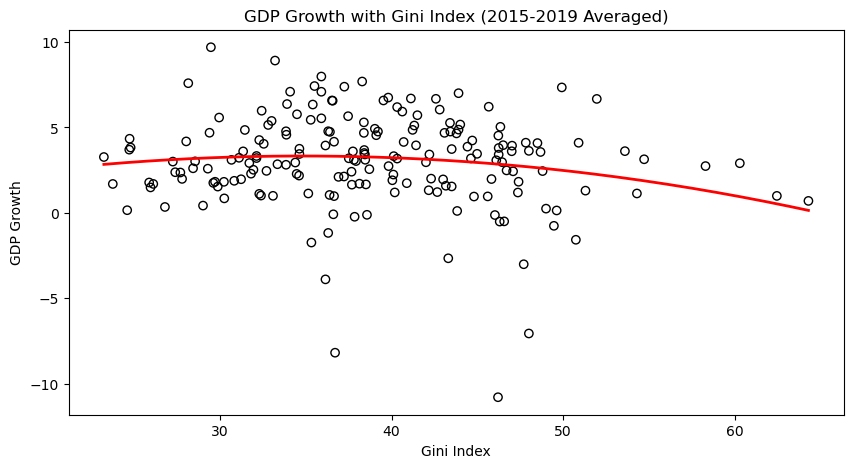

In [26]:
# Dropping missing values
wb_plot = wb_avg.dropna(subset=['GDP_Growth', 'Gini_Index'])

# Defining x and y
x = wb_plot['Gini_Index'].values
y = wb_plot['GDP_Growth'].values

# Fitting quadratic polynomial line
coef = np.polyfit(x, y, deg=2)
poly = np.poly1d(coef)

# Generating fitted curve
x_curve = np.linspace(x.min(), x.max(), 200)
y_curve = poly(x_curve)

# Defining plot and size
plt.figure(figsize=(10,5))

# Defining scatter
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='k')

# Plotting quadratic curve
plt.plot(x_curve, y_curve, color="red", linewidth=2)

# Labels
plt.xlabel('Gini Index')
plt.ylabel('GDP Growth')

# Title
plt.title('GDP Growth with Gini Index (2015-2019 Averaged)')

plt.show()

# Implications Of The Graph
We can see a weak non-linear relationship which resembles an inverted U-shape, so there is some empirical support for including the non-linear term.

# Step 4: Economic Analysis
## Question 1: Is there evidence of the Kuznets hypothesis when examining the effect between GDP growth and inequality?
We define the equation as:

$$
\begin{aligned}
\overline{\text{GDP\_Growth}}_{i}
&= \beta_0
+ \beta_1 \,\overline{\text{Gini}}_{i}
+ \beta_2 \,\overline{\text{Gini}}^{\,2}_{i}
+ \beta_3 \log(\overline{\text{GDP\_Pc}}_{i})
+ \beta_4 \log(\overline{\text{Educ\_Exp}}_{i}) \\
&\quad
+ \beta_5 \log(\overline{\text{Trade}}_{i})
+ \beta_6 \,\overline{\text{Govt\_Effectiveness}}_{i}
+ \beta_7 \left(\overline{\text{Educ\_Exp}}_{i} \times \overline{\text{Govt\_Effectiveness}}_{i}\right)
+ \text{ε}_{i}
\end{aligned}
$$

Our dependent variable here is GDP growth and the main explanatory variables are Gini and Gini squared. Here we aim to find the **between** country effect, we define a time period [2015-2019] and take the average of all variables over this period. This fixed the time variable and turns the panel into a cross-section.

In [27]:
# Statistical significance helper function
def stat_significance(est):
    p_values = est.pvalues
    for feature, p in p_values.items():
        if p <= 0.01:
            print(f"{feature}: {p} -- Reject at 1% significance level\n")
        elif p <= 0.05:
            print(f"{feature}: {p} -- Reject at 5% significance level\n")
        elif p<= 0.1:
            print(f"{feature}: {p} -- Reject at 10% significance level\n")
        else:
            print(f"{feature}: {p} -- Fail to reject at 10% significance level\n")


In [28]:
# Question 1

# Setting up formula
formula_1 = (""
           "GDP_Growth ~ Gini_Index + Gini_Sq + "
           "GDP_Pc_Log + Educ_Log + Trade_Log + "
             "Govt_Effectiveness +"
             "Educ_Govt_Eff"
             )

# List of variables on which to drop rows (interaction excluded)
vars_1 = ['GDP_Growth', 'Gini_Index', 'Gini_Sq',
        'GDP_Pc_Log', 'Educ_Log', 'Trade_Log',
          'Govt_Effectiveness']

# Rows before
before = wb_avg.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q1 = wb_avg.dropna(subset=vars_1)

# Rows after
after = wb_q1.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_1, data=wb_q1, return_type='dataframe')

# Defining OLS model
model_1 = sm.OLS(y, X)

# Estimating
estimate_1 = model_1.fit()

print(estimate_1.summary())

stat_significance(estimate_1)

We dropped 20.93% rows
                            OLS Regression Results                            
Dep. Variable:             GDP_Growth   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     8.870
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           3.16e-09
Time:                        19:59:48   Log-Likelihood:                -376.89
No. Observations:                 170   AIC:                             769.8
Df Residuals:                     162   BIC:                             794.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept    

# Summary Table Interpretation
Partial equation of key variables:
$$
\begin{aligned}
\frac{\partial\, \widehat{\text{GDP\_Growth}}}{\partial\, \text{Gini}}
&= \beta_{1} + 2\beta_{2}\,\text{Gini} \\
&= 0.214 + 2(-0.00289)\,\text{Gini}
\end{aligned}
$$
We can find the turning point:
$$
\begin{aligned}
0.214 + 2(-0.00289)\,\text{Gini} = 0 \\
\text{Gini} = 37.04
\end{aligned}
$$
GDP Growth is rising in Gini but at a decreasing rate. It starts falling after the turning point. Interpretation: (i) in very equal societies increasing inequality can increase GDP Growth, (ii) in less equal societies increasing inequality can increase GDP Growth by less, (iii) at the turning point, every subsequent increase will lead to lower growth.

Of note here is that the two variables are not statistically significant at 10% significance level. We will explore why.

# 1a. Is the inference reliable?
We need to test if the residuals are heteroskedastic. We use White's test and confidently reject the null of homoskedasticity at a 0.01% level of significance. We fit the model again with robust standard errors.

In [29]:
## Testing for heteroskedasticity

# White's test
lm_stat, lm_p, f_stat, f_p = het_white(estimate_1.resid, X)

print(f"White LM P-value: {lm_p}")
print(f"White F-test P-value: {f_p}")
# We reject the null of homoskedasticity at all levels of significance

# Estimating with robust standard errors
estimate_robust = model_1.fit(cov_type='HC1')

# Comparing robust results with homoskedastic in a dataframe
comparative_df = pd.DataFrame({
    "Coeff" : estimate_1.params,
    "SE_Homoskedastic" : estimate_1.bse,
    "SE_Robust" : estimate_robust.bse,
    "t_Homoskedastic" : estimate_1.tvalues,
    "t_Robust" : estimate_robust.tvalues,
    "p_Homoskedastic" : estimate_1.pvalues,
    "p_Robust" : estimate_robust.pvalues
})
# Applying map to format all values to 3sf on every column
for col in comparative_df.columns:
    comparative_df[col] = comparative_df[col].map('{:.3g}'.format)
comparative_df

White LM P-value: 9.193359556985656e-09
White F-test P-value: 1.243616099995026e-14


,Coeff,SE_Homoskedastic,SE_Robust,t_Homoskedastic,t_Robust,p_Homoskedastic,p_Robust
Intercept,13.7,5.11,5.12,2.67,2.67,0.00833,0.00762
Gini_Index,0.214,0.18,0.141,1.18,1.52,0.238,0.129
Gini_Sq,-0.00288,0.00215,0.00159,-1.34,-1.82,0.182,0.0693
GDP_Pc_Log,-1.77,0.258,0.296,-6.85,-5.98,1.42e-10,2.17e-09
Educ_Log,-1.2,0.519,0.491,-2.32,-2.44,0.0218,0.0145
Trade_Log,0.656,0.367,0.387,1.79,1.69,0.0759,0.0902
Govt_Effectiveness,2.99,0.55,0.782,5.44,3.82,1.97e-07,0.000132
Educ_Govt_Eff,-0.375,0.239,0.215,-1.57,-1.74,0.119,0.0815


+ Coefficients don't change, SEs and t-tests do
+ SEs for some variables are increasing, less statistically significant
+ Gini SE decreased, more statistically significant

# 1b. Does inequality and its non-linear transformation jointly influence growth?
Testing the joint hypothesis that the coefficients of Gini and Gini Squared are significantly different form 0.
$$
\begin{aligned}
H_{0}: \beta_{\text{Gini}} = 0 \ \text{and}\ \beta_{\text{Gini}^2} = 0 \\
H_{1}: \beta_{\text{Gini}} \neq 0 \ \text{or}\ \beta_{\text{Gini}^2} \neq 0
\end{aligned}
$$

In [30]:
F_results = estimate_robust.f_test("Gini_Index = 0, Gini_Sq = 0")
print(F_results)

<F test: F=3.0463429127964865, p=0.05026457803442638, df_denom=162, df_num=2>


We reject the null at 10% significance level. There is some evidence that they jointly affect growth

# 1c. Is inequality's effect on GDP Growth non-linear?
Testing the hypothesis that the coefficient on Gini squared is significantly different from 0:
$$
\begin{aligned}
H_{0}: \beta_{\text{Gini}^2} = 0 \\
H_{1}: \beta_{\text{Gini}^2} \neq 0
\end{aligned}
$$

In [31]:
t_results = estimate_robust.t_test("Gini_Sq = 0")
print(t_results)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0029      0.002     -1.817      0.069      -0.006       0.000


We can reject the null at 10% confidence level. There is evidence that the effect of Gini on Growth is non-linear.

# 1d. Why were inference tests in our summary table unreliable?
Gini and Gini squared are almost perfectly colinear, making the OLS estimator imprecise. The joint F-test used their combined variation combined to explain the variation in the dependent variable. This couldn't be done individually since they were close to perfect correlation. We calculate the correlation of the two variables in the next code cell:

In [32]:
corr_gini = wb_q1['Gini_Index'].corr(wb_q1['Gini_Sq'])
print(corr_gini)

0.9905074992627813


## Question 2: Does greater international trade integration **within a country** lead to higher FDI inflows **over time**?
We define:
$$
\begin{aligned}
\log(\text{FDI}_{it})
&= \beta_0
+ \beta_1 \log(\text{Trade}_{it})
+ \beta_2 \log(\text{GDP\_Pc}_{it})
+ \beta_3 \,\text{Gini}_{it}
+ \beta_4 \,\text{Gini}^2_{it}
+ \beta_5 \,\text{Reg\_Quality}_{it}
\\[1em]
&\quad
+ \beta_6 \left( \text{Reg\_Quality}_{it} \times \log(\text{GDP\_Pc}_{it}) \right)
+ \beta_7 \left( \log(\text{Trade}_{it}) \times \text{Reg\_Quality}_{it} \right)
+  \text{α}_{i}
+  \text{λ}_{t}
+ \text{ε}_{it}
\end{aligned}
$$

We estimate the **within** country effect, with fixed effects. We have both entity and time FEs.

In [33]:
# Question 2

# Setting up formula
formula_2 = (""
           "FDI_Log ~ Trade_Log + GDP_Pc_Log + "
           "Gini_Index + Gini_Sq + Reg_Quality + "
             "GDP_RegQ + Trade_RegQ"
             )

# List of variables on which to drop rows (interaction excluded)
vars_2 = ['FDI_Log', 'Trade_Log', 'GDP_Pc_Log',
        'Gini_Index', 'Gini_Sq', 'Reg_Quality',
          'GDP_RegQ', 'Trade_RegQ']

# Rows before
before = wb_imputed.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q2 = wb_imputed.dropna(subset=vars_2)

# Setting multi-index
wb_q2 = wb_q2.set_index(['iso3', 'year'])

# Rows after dropping missing values
after = wb_q2.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_2, data=wb_q2, return_type='dataframe')

# Defining OLS model
model_2 = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)

# Estimating
estimate_2 = model_2.fit(cov_type='clustered', cluster_entity=False)

print(estimate_2.summary)

stat_significance(estimate_2)

We dropped 20.69% rows
                          PanelOLS Estimation Summary                           
Dep. Variable:                FDI_Log   R-squared:                        0.0159
Estimator:                   PanelOLS   R-squared (Between):              0.0832
No. Observations:                3581   R-squared (Within):               0.0241
Date:                Tue, Dec 02 2025   R-squared (Overall):              0.0448
Time:                        20:00:04   Log-likelihood                   -5094.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.7780
Entities:                         174   P-value                           0.0000
Avg Obs:                       20.580   Distribution:                  F(7,3380)
Min Obs:                       5.0000                                           
Max Obs:                       21.000   F-statistic (robust):             9.4039
     

# Summary Table Interpretation
Both key variables $[log(Trade), log(Trade*RegQ)]$ are statistically significant. Taking the partial derivative:
$$
\begin{aligned}
\frac{\partial \log(\text{FDI}_{it})}{\partial \log(\text{Trade}_{it})}
&= \beta_1 + \beta_7\,\text{Reg\_Quality}_{it}. \\
&= 0.4006 - 0.3582\, \text{Reg\_Quality}_{it}
\end{aligned}
$$
 There is a turning point at:
$$
\begin{aligned}
0.4006 - 0.3582\,\text{Reg\_Quality}_{it} &= 0 \\[0.5em]
\text{Reg\_Quality}_{it} &= \frac{0.4006}{0.3582} \approx 1.12
\end{aligned}
$$
We are controlling for time-invariant country characteristics and global shocks. FDI is increasing in trade openness **within** a country, but the magintude relies on regulatory quality. A 1% increase in trade open. increases FDI by 0.4%, if regulatory quality is 0. Each one-unit increase in Reg. Quality reduces the elasticity between trade open. and FDI by 0.36 percentage points.After the turning point, the effect of Trade on FDI becomes negative

Increases in trade openness raise FDI inflows relative to a country's past if it's regulatory quality is weak. As its reg. quality increases the effect diminishes and eventually reverses.

# 2a. What is the interpretation of the fixed effect constants?


In [34]:
# Extracting fixed effects
effects_est = estimate_2.estimated_effects

# Printing first few rows
print(effects_est.head(20))

           estimated_effects
iso3 year                   
AFG  2002          -0.656935
     2003          -0.641077
     2004          -0.466811
     2005          -0.336210
     2006          -0.081283
     2007           0.033667
     2008          -0.098895
     2009          -0.376883
     2010          -0.398995
     2011          -0.246179
     2012          -0.279295
     2013          -0.463510
     2014          -0.441084
     2015          -0.427937
     2016          -0.414770
     2017          -0.455054
     2018          -0.641817
     2019          -0.539043
     2020          -0.971656
     2021          -0.450024


The estimated effect values are capturing: (i) time-invariant country characteristics, e.g. history, culture, geography, and (ii) global shocks that vary through time, such as recessions and crises (e.g. Covid-19). Time fixed effects are causing the value to oscillate around the country FE constant.

# 2b. Is the model overfitting?
We will check if the model is overidentified using LASSO variable selection. Firstly we need to demean the data to remove country and time fixed effects:
$$
\begin{align}
\tilde{y}_{it} = y_{it} - \overline{y}_{i} - \overline{y}_{t} + \overline{y}
\\[1em]
\tilde{x}_{it} = x_{it} - \overline{x}_{i} - \overline{x}_{t} + \overline{x}
\end{align}
$$

We then run LASSO cross-validation to discover the optimal penalty value, alpha. Finally, we run the LASSO model using the penalty and interpret the coefficient selection.

## Demeaning Helper Function

In [35]:
# Generalised demeaning helper function
# Declaring helper demeaning function to re-use
def demean_2FE(df):
    # Copying dataframe
    df_fe = df.copy()
    # Looping over all columns
    for col in df.columns:
        # Grouping by FE type and and create mean vector
        e_mean = df_fe[col].groupby(level='iso3').transform('mean')
        t_mean = df_fe[col].groupby(level='year').transform('mean')
        total_mean = df_fe[col].mean()
        # Demeaning
        df_fe[col] = df_fe[col] - e_mean - t_mean + total_mean
    return df_fe

## Calculating LASSO

The penalty selected through cross-validation is 0.002452577153186399

Trade_Log      0.075532
GDP_Pc_Log    -0.002693
Gini_Index     0.000000
Gini_Sq       -0.012081
Reg_Quality    0.254531
GDP_RegQ      -0.021059
Trade_RegQ    -0.213069
dtype: float64 



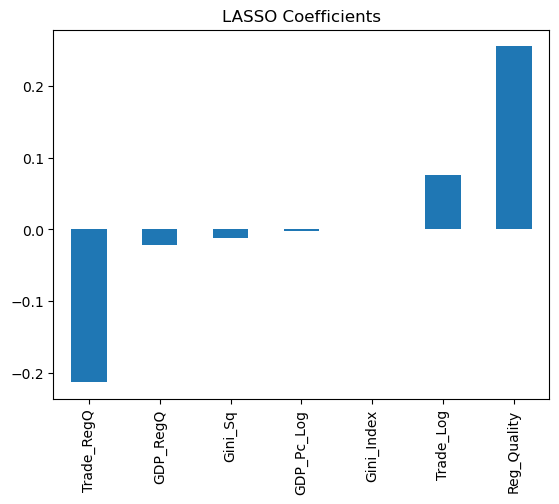

In [36]:
## Testing for Robustness using LASSO

# Combining X and y
df_dm = pd.concat([y, X], axis=1)

# Applying demeaning function to df
df_dm = demean_2FE(df_dm)

# Listwise deletion of empty value rows
df_dm = df_dm.dropna(how='any')

# Splitting into X by taking all rows and all columns less the first
X_2FE = df_dm.iloc[:, 1:]

# Splitting into y by taking all rows and first column
y_2FE = df_dm.iloc[:, 0]

# Dropping intercept column
X_2FE = X_2FE.drop(columns=['Intercept'])

# Standardising X
X_std = (X_2FE - X_2FE.mean()) / X_2FE.std()

# Running LASSO cross-validation to find penalty
Lasso_cv = LassoCV(cv=5, random_state=0)
estimate_cv = Lasso_cv.fit(X_std, y_2FE)

# Defining penalty variable
penalty = estimate_cv.alpha_
print(f"The penalty selected through cross-validation is {penalty}\n")

# Running Lasso model
Lasso_model = linear_model.Lasso(alpha=penalty)
estimate_lasso = Lasso_model.fit(X_std, y_2FE)

# Extracting coefficient series
coefs = pd.Series(estimate_lasso.coef_, index=X_2FE.columns)
print(coefs, "\n")

# Plotting coefficients
coefs.sort_values().plot(kind='bar')
plt.title("LASSO Coefficients")
plt.show()

# LASSO Coefficients
Variables with higher coefficients are deemed to have more explanatory power by LASSO. Linear Gini was dropped, we re-fit the values without Gini:

In [37]:
# Defining post-Lasso dataframe by dropping Gini
X_post = X.drop(columns=['Gini_Index'])

# Running Panel OLS
model_2b = PanelOLS(y, X_post, entity_effects=True, time_effects=True, drop_absorbed=True)
estimate_2b = model_2b.fit(cov_type='clustered', cluster_entity=False)


# Comparing the two results
comparative_table = compare({
    'Pre-LASSO OLS' : estimate_2,
    'Post-LASSO OLS' : estimate_2b
})
print(comparative_table)
stat_significance(estimate_2b)

                  Model Comparison                  
                        Pre-LASSO OLS Post-LASSO OLS
----------------------------------------------------
Dep. Variable                 FDI_Log        FDI_Log
Estimator                    PanelOLS       PanelOLS
No. Observations                 3581           3581
Cov. Est.                   Clustered      Clustered
R-squared                      0.0159         0.0154
R-Squared (Within)             0.0241         0.0233
R-Squared (Between)            0.0832         0.0909
R-Squared (Overall)            0.0448         0.0457
F-statistic                    7.7780         8.8090
P-value (F-stat)               0.0000         0.0000
=====================     ===========    ===========
Intercept                     -1.3160         0.9389
                            (-0.4891)       (0.7180)
Trade_Log                      0.4006         0.3971
                             (2.6679)       (2.6575)
GDP_Pc_Log                    -0.0691        -

# Interpretation of LASSO selection model results
Our key metric is R squared, it largely remains the same and the coefficients remain stable. This is evidence that the model was overfitting Pre-LASSO, none of its explanatory power was lost when Gini was dropped.

## Question 3: Does higher spending on education **within a country** translate to increased growth?
We define:
$$
\begin{aligned}
\text{GDP\_Growth}_{it}
&= \beta_0
+ \beta_1 \,\text{Educ\_Log}_{it}
+ \beta_2 \,\text{Trade\_Log}_{it}
+ \beta_3 \,\text{Gini\_Index}_{it}
+ \beta_4 \,\text{Gini\_sq}_{it}
+ \beta_5 \,\text{Govt\_Effectiveness}_{it}
\\[1em]
&\quad
+ \beta_6 \left( \text{Educ\_Log}_{it} \times \text{Govt\_Effectiveness}_{it} \right)
+ \alpha_i
+ \lambda_t
+ \varepsilon_{it}
\end{aligned}
$$

We aim to estimate the **within** country effect of education spending on growth, using FEs. Our dependent variable is GDP Growth and our main explanatory variable is the log of Education Spending.

In [38]:
# Question 3

# Setting up formula
formula_3 = (""
           "GDP_Growth ~ Educ_Log + Trade_Log + "
           "Gini_Index + Gini_Sq + Govt_Effectiveness + "
             "Educ_Govt_Eff"
             )

# List of variables on which to drop rows (interaction excluded)
vars_3 = ["GDP_Growth", 'Educ_Log', 'Trade_Log',
          'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness',
          'Educ_Govt_Eff']

# Rows before
before = wb_imputed.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q3 = wb_imputed.dropna(subset=vars_3)

# Setting multi-index
wb_q3 = wb_q3.set_index(['iso3', 'year'])

# Rows after
after = wb_q3.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_3, data=wb_q3, return_type='dataframe')

# Defining OLS model
model_3 = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)

# Estimating
estimate_3 = model_3.fit(cov_type='clustered', cluster_entity=False)

print(estimate_3.summary)

stat_significance(estimate_3)

We dropped 21.66% rows
                          PanelOLS Estimation Summary                           
Dep. Variable:             GDP_Growth   R-squared:                        0.0270
Estimator:                   PanelOLS   R-squared (Between):             -1.5838
No. Observations:                3537   R-squared (Within):               0.0401
Date:                Tue, Dec 02 2025   R-squared (Overall):             -0.2160
Time:                        20:00:18   Log-likelihood                -1.007e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      15.443
Entities:                         170   P-value                           0.0000
Avg Obs:                       20.806   Distribution:                  F(6,3341)
Min Obs:                       9.0000                                           
Max Obs:                       21.000   F-statistic (robust):             9.9387
     

# Summary Table Interpretation
The interaction term is statistically insignificant, so the marginal effect of education spending on growth is just $\beta_1 = -1.4678$. A 1% increase in education spending is associated with a -0.0147 **percentage point decrease** in GDP Growth. The interpretation here is not clear yet as we suspect endogeneity. Education Spending and GDP Growth likely exhibit simultaneity as we expect them to be jointly determined.

# 3a. Is there endogeneity and how do we address it?

Endogeneity biases the estimates and makes the OLS estimators inconsistent. A relevant and valid instrument can mitigate this. A candidate instrument is the lag of Education Expenditure. We assume past education spending only affects current economic growth through current education spending. We also expect for current education spending to be related to past spending.

IV for Education Expenditure:
$Z_{1, it} = \text{Educ\_Log}_{i(t-1)}$

IV Interaction Term:
$
Z_{2, it} = Z_{1, it} \times \text{Govt\_Effectiveness}_{it} = \text{Educ\_Log}_{i(t-1)} \times \text{Govt\_Effectiveness}_{it}
$

In [39]:
# Recreating dataframe for replicability
wb_q3 = wb_imputed.copy()
wb_q3 = wb_q3.dropna(subset=vars_3)

## Creating lagged education variable
wb_q3['Educ_Lag1'] = wb_q3.groupby('iso3')['Educ_Log'].shift(1)

# Creating lagged interaction
wb_q3['Educ_Govt_Lag'] = wb_q3['Educ_Lag1'] * wb_q3['Govt_Effectiveness']

# Setting multi-index
wb_q3 = wb_q3.set_index(['iso3', 'year'])

## Defining model specifications

# Creating new dataframe with all endogenous, exogenous and instruments
df_iv = wb_q3[['GDP_Growth',
               'Educ_Log', 'Educ_Govt_Eff', # endogenous
               'Educ_Lag1', 'Educ_Govt_Lag', # instruments
               'Trade_Log', 'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness' # controls
               ]]

# Applying demeaning to df
df_iv = demean_2FE(df_iv)

# Dropping empty rows
df_iv = df_iv.dropna(how='any')

# Defining endogenous, exogenous, instruments and dependent frames
y = df_iv['GDP_Growth']
endog = df_iv[['Educ_Log', 'Educ_Govt_Eff']]
exog = df_iv[['Trade_Log', 'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness']]
instruments = df_iv[['Educ_Lag1', 'Educ_Govt_Lag']]

# IV model
model_IV = IV2SLS(dependent=y,
                  exog=exog,
                  endog=endog,
                  instruments=instruments)

# Fitting model
estimate_IV = model_IV.fit(cov_type='robust')

# 3b. What is the interpretation of the first-stage 2SLS result?
We estimate $\widehat{E}_{it}$ and $\widehat{\Psi}_{it}$ from:

(1)
\begin{aligned}
E_{it}
= \text{Educ\_Log}_{it}
&= \pi_0
+ \pi_1\,\text{Educ\_Log}_{i,t-1}
+ \pi_2 \left( \text{Educ\_Log}_{i,t-1} \times \text{Govt\_Effectiveness}_{it} \right)
+ \delta' X_{it}
+ \alpha_i + \lambda_t
+ u_{1,it}
\\[0.75em]
&= \pi_0
+ \pi_1 Z_{1,it}
+ \pi_2 Z_{2,it}
+ \delta' X_{it}
+ \alpha_i + \lambda_t
+ u_{1,it}.
\end{aligned}

(2)
\begin{aligned}
\Psi_{it}
= \left( \text{Educ\_Log}_{it} \times \text{Govt\_Effectiveness}_{it} \right)
&= \phi_0
+ \phi_1\,\text{Educ\_Log}_{i,t-1}
+ \phi_2 \left( \text{Educ\_Log}_{i,t-1} \times \text{Govt\_Effectiveness}_{it} \right)
+ \theta' X_{it}
+ \alpha_i + \lambda_t
+ u_{2,it}
\\[0.75em]
&= \phi_0
+ \phi_1 Z_{1,it}
+ \phi_2 Z_{2,it}
+ \theta' X_{it}
+ \alpha_i + \lambda_t
+ u_{2,it}.
\end{aligned}

*Note: **X** is the vector of exogenous controls.*


In [40]:
# First stage result
print(estimate_IV.first_stage)

           First Stage Estimation Results           
                              Educ_Log Educ_Govt_Eff
----------------------------------------------------
R-squared                       0.4852        0.9154
Partial R-squared               0.4755        0.7777
Shea's R-squared                0.4925        0.8055
Partial F-statistic             287.28        1317.4
P-value (Partial F-stat)        0.0000        0.0000
Partial F-stat Distn           chi2(2)       chi2(2)
========================== ===========   ===========
Trade_Log                    6.414e-06       -0.0262
                              (0.0004)     (-1.9341)
Gini_Index                      0.0084       -0.0135
                              (1.1723)     (-2.1166)
Gini_Sq                        -0.0002        0.0002
                             (-2.1310)      (2.4286)
Govt_Effectiveness              0.0231        0.1147
                              (1.0090)      (2.8146)
Educ_Lag1                       0.6894        

The partial R-squareds are: 0.48 and 0.78, the instrument are explaining 48% and 78% of the variation in the endogenous variables. The partial F-statistics are: 287.28 and 1317.4. An F-statistic greater than 10 usually signifies a strong instrument so our instruments are exceptionally strong.

# 3c. What is the 2nd-stage interpretation?
We estimate the full regression using the first-stage estimates:

$$
\text{GDP\_Growth}_{it}
=
\beta_0
+ \beta_1\,\widehat{E}_{it}
+ \beta_2\,\widehat{\Psi}_{it}
+ \boldsymbol{\gamma}' X_{it}
+ \alpha_i
+ \lambda_t
+ \varepsilon_{it}.
$$


In [41]:
# 2nd stage result
print(estimate_IV.summary)

# printing OLS summary for comparison
print(estimate_3.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:             GDP_Growth   R-squared:                      0.0264
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0246
No. Observations:                3367   F-statistic:                    71.963
Date:                Tue, Dec 02 2025   P-value (F-stat)                0.0000
Time:                        20:00:22   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Trade_Log              4.5001     0.5783     7.7818     0.0000      3.3667      5.6335
Gini_Index          

### Results
- OLS coefficients and p-values:
    - $\beta_{EducLog}^{OLS} = -0.8 \; (p = 0.14)$
    - $\beta_{Educ_Govt_Eff}^{OLS} = 0.27 \; (p = 0.35)$

- IV coefficients and p-values:
    - $\beta_{EducLog}^{IV} = 0.94 \; (p = 0.19)$
    - $\beta_{Educ_Govt_Eff}^{IV} = 0.77 \; (p = 0.0377)^{**}$

In the IV model both estimated coefficients increased in absolute magnitude and the coefficient on Educ_Log changed sign to positive. This is a strong hint that endogeneity bias was pushing the coefficients downwards in OLS with FEs. The coefficient on Educ_Log is still insignificant but the coefficient on the interaction is now significant at 5% significance level.

### Economic Intepretation
We can take the partial derivative:
$$
\frac{\partial \, GDP\_Growth}{\partial \, Educ\_Log}
= 0.94 \; + \; 0.77 \cdot \text{Government\_Eff}
$$
The marginal effect of education spending on growth is increasing in Government Effectiveness. The interpretation is that for a given figure of education spending, there would be higher growth returns for more efficient governments. This could be caused by e.g. (i) allocative inefficiency; corruption causes funds allocated to education to be mismanaged, (ii) time-lags: returns to education take years to appear; effective governments can better sustain stable education reform without disruption

# 3d. Are the regressors endogenous?
We can test whether the two variables we instrumented were endogenous using a Wu-Hausman endogeneity test. The test estimates two-reduced form regressions for our two candidate endogenous regressors and uses them in the structural equation. If the coefficients on the residuals are statistically different from 0 we have endogeneity in the model, as the component the instrument doesn't explain is correlated with the error term in the structural equation. (Wooldridge, 2016, p. 482) In other words we are testing the joint hypothesis:

\begin{aligned}
H_0: \delta_1 = \delta_2 = 0 \quad \text{(no endogeneity)} \\[6pt]
H_1: \delta_1 \neq 0 \quad \text{or} \quad \delta_2 \neq 0 \quad \text{(at least one endogenous regressor)}
\end{aligned}

In [42]:
# Calculating wu hausman test results
wu_haus = estimate_IV.wu_hausman()
print(wu_haus, '\n')

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 9.2634
P-value: 0.0001
Distributed: F(2,3359) 



## Results
Our p-value is 0.0001 so we strongly reject the null of exogeneity at 0.01% significance level. At least one of our variables is endogenous and our IV estimates should be preferred over the OLS.

# Step 5: Conclusion
 Our analysis led to many interesting conclusions. In the first regression we managed to link the Kuznets hypothesis with our data through the partial derivative with respect to Gini. We investigated properties of the OLS estimator and their implications on inference testing, linking it back to certain properties of our variables.

The second regression focused on within-country variation using FEs. Our results indicated that a rise in FDI inflows is associated with an increase in Trade Openness, reliying on regulatory quality. LASSO was used for feature selection and the model pointed towards Regulatory Quality and its interaction as being the most important variables, along with Gini being the weakest. We investigated why the Gini variable was dropped by looking at the R^2 of the model, it was potentially overfitting.

The final regression estimated the within-country effect of greater education spending on growth, with FEs. We  suspected endogeneity in the model and used an instrument, fitting with 2SLS. We observed how endogeneity was biasing our previous estimates and explicitly tested for it with the Wu-Hausman test. The results pointed towards endogenous regressors, so we established our preference for the IV estimates.

To improve the project we could expand the time-frame of the panels and use additional estimators. Widening the time window increases within-country variation so our fixed effect estimates become more reliable, there is more variation for them to use when controlling for unobservables. Additionally, other estimators could be used: Generalized Method of Moments (GMM) handles panel models and remains efficient under heteroskedasticity. Machine learning model such as XGBoost can detect non-linear effects and are able to handle multicollinearity. Other estimators can be used when OLS MLR assumptions fail, which often happened in our regressions (multicollinearity, endogeneity, heteroskedasticity)

# References
Bellemare, M.F. and Wichman, C.J. (2020)
‘Elasticities and the inverse hyperbolic sine transformation’, Oxford Bulletin of Economics and Statistics, 82(1), pp. 50–61. doi:10.1111/obes.12325.

Solt, F. (2019)
‘The Standardized World Income Inequality Database, Version 9’, Harvard Dataverse. doi:10.7910/DVN/LM4OWF.

World Bank (2024a)
Worldwide Governance Indicators: Documentation. Washington, DC: World Bank. Available at:
https://www.worldbank.org/en/publication/worldwide-governance-indicators/documentation

(Accessed: 14 November 2025).

World Bank (2024b)
Government Effectiveness: Representative Sources. Washington, DC: World Bank. Available at:
https://www.worldbank.org/content/dam/sites/govindicators/doc/ge.pdf

(Accessed: 14 November 2025).

World Bank (2025a)
World Development Indicators: Indicator Database. Washington, DC: World Bank. Available at:
https://data.worldbank.org/indicator/

(Accessed: 9 November 2025).

World Bank (2025b)
Poverty and Inequality – World Development Indicators. Washington, DC: World Bank. Available at:
https://datatopics.worldbank.org/world-development-indicators/themes/poverty-and-inequality.html

(Accessed: 9 November 2025).

World Bank (2025c)
People – World Development Indicators. Washington, DC: World Bank. Available at:
https://datatopics.worldbank.org/world-development-indicators/themes/people.html

(Accessed: 9 November 2025).

World Bank (2025d)
Regulatory Quality: Sources and Methodology. Washington, DC: World Bank. Available at:
https://www.worldbank.org/content/dam/sites/govindicators/doc/rq.pdf

(Accessed: 26 November 2025).

World Bank (2025e)
Foreign direct investment, net inflows (% of GDP) [Indicator: BX.KLT.DINV.WD.GD.ZS]. Washington, DC: World Bank. Available at:
https://data.worldbank.org/indicator/BX.KLT.DINV.WD.GD.ZS

(Accessed: 14 November 2025).

Wooldridge, J.M. (2016)
Introductory Econometrics: A Modern Approach. 6th edn. Boston, MA: Cengage Learning.